In [1]:
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_Vina.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

In [2]:
import os
import pandas as pd
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_Vina.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

def split_and_save_csv_files(output_subfolder_vina, output_subfolder_vinardo):
    # Retrieve the directories from the config variable
    source_directory = config['source_directory']
    output_directory = config['output_directory']
    
    # Define the output directories
    vina_directory = os.path.join(output_directory, output_subfolder_vina)
    vinardo_directory = os.path.join(output_directory, output_subfolder_vinardo)
    
    # Ensure the output directories exist
    os.makedirs(vina_directory, exist_ok=True)
    os.makedirs(vinardo_directory, exist_ok=True)
    
    # Iterate through each file in the source directory
    for file in os.listdir(source_directory):
        if file.endswith('.csv'):
            file_path = os.path.join(source_directory, file)
            df = pd.read_csv(file_path)
            
            # Split the dataframe based on the scoring function
            df_vina = df[df['scoring_function'] == 'vina']
            df_vinardo = df[df['scoring_function'] == 'vinardo']
            
            # Define the base filename without extension and the new file paths
            base_filename = file.rsplit('.', 1)[0]
            file_path_vina = os.path.join(vina_directory, f"{base_filename}_vina.xlsx")
            file_path_vinardo = os.path.join(vinardo_directory, f"{base_filename}_vinardo.xlsx")
            
            # Save the dataframes to Excel files
            df_vina.to_excel(file_path_vina, index=False)
            df_vinardo.to_excel(file_path_vinardo, index=False)
            
            #print(f"Processed and saved: {file}")

# Example usage
output_subfolder_vina = 'Vina_TF_ex'
output_subfolder_vinardo = 'Vinardo_TF_ex'
split_and_save_csv_files(output_subfolder_vina, output_subfolder_vinardo)


In [4]:
import os
import pandas as pd
import json


def sort_excel_files_in_directory(input_subfolder, output_subfolder):
    # Retrieve the output directory from the config variable
    output_directory_base = config['output_directory']
    
    # Define the directory path containing the Excel files
    directory_path = os.path.join(output_directory_base, input_subfolder)
    
    # Define the output directory for sorted files
    output_directory = os.path.join(output_directory_base, output_subfolder)
    
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # List all Excel files in the directory
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]

    # Process each file
    for file in excel_files:
        file_path = os.path.join(directory_path, file)
        try:
            # Load the Excel file
            data = pd.read_excel(file_path)

            # Sort the data by the 'total' column
            sorted_data = data.sort_values(by='total', ascending=True)

            # Add a new column 'vina_rank' with numbers from 0 to 999
            # Note: Ensure there are at least 1000 rows, otherwise adjust the range accordingly
            if len(sorted_data) >= 1000:
                sorted_data['vinardo_rank'] = range(1000)
            else:
                sorted_data['vinardo_rank'] = range(len(sorted_data))

            # Define the output file path
            output_file_path = os.path.join(output_directory, f'sorted_{file}')

            # Save the sorted data to a new Excel file
            sorted_data.to_excel(output_file_path, index=False)
            
            #print(f'Successfully sorted and saved: {output_file_path}')
        except Exception as e:
            print(f'Error processing file {file}: {e}')

# Example usage
input_subfolder = 'Vinardo_TF_ex'  # Subfolder name where the Excel files are located
output_subfolder = 'Vinardo_TF_ex_sorted'  # Subfolder name where sorted Excel files will be saved

sort_excel_files_in_directory(input_subfolder, output_subfolder)


In [5]:
import pandas as pd
import os
import re
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_Vina.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

def extract_rank(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def process_excel_files(input_subfolder, output_subfolder):
    # Retrieve the base output directory from the config variable
    output_directory_base = config['output_directory']
    
    # Define the input and output directory paths
    input_directory = os.path.join(output_directory_base, input_subfolder)
    output_directory = os.path.join(output_directory_base, output_subfolder)
    
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    problematic_files = []

    # Process each file in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.xlsx') or filename.endswith('.xls'):
            file_path = os.path.join(input_directory, filename)
            output_file_path = os.path.join(output_directory, filename)
            try:
                xls = pd.ExcelFile(file_path, engine='openpyxl')
                dfs = {}
                for sheet_name in xls.sheet_names:
                    df = xls.parse(sheet_name)
                    if sheet_name == 'Sheet1':
                        df['alphafold rank'] = df['file'].apply(extract_rank)
                        cols = ['alphafold rank'] + [col for col in df if col != 'alphafold rank']
                        df = df[cols]
                        df = df[~df['file'].str.contains("native", case=False, na=False)]
                    dfs[sheet_name] = df
                with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
                    for sheet_name, df in dfs.items():
                        df.to_excel(writer, sheet_name=sheet_name, index=False)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
                problematic_files.append(filename)

    if problematic_files:
        print("Problematic files:", problematic_files)
    else:
        print("All files have been processed successfully.")

# Example usage
input_subfolder = 'Vinardo_TF_ex_sorted'  # Subfolder name where the Excel files are located
output_subfolder = 'Vinardo_sorted_TF_alpha_rank'  # Subfolder name where processed Excel files will be saved

process_excel_files(input_subfolder, output_subfolder)


All files have been processed successfully.


In [6]:
import os
import shutil
import pandas as pd
from openpyxl import load_workbook

# Assuming the configuration is already loaded and available as the global variable 'config'
def extract_pdb_id_from_dockq(filename):
    """Extracts the PDB ID from a DockQ filename."""
    parts = filename.split('_')
    return parts[0]  # PDB ID is the first part

def extract_pdb_id_from_vina(filename):
    """Extracts the PDB ID from a vina filename."""
    parts = filename.split('_')
    return parts[1]  # PDB ID is after 'vina_scoring'

def copy_vina_sheets_to_dockq(dockq_dir, vina_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    dockq_files = os.listdir(dockq_dir)
    vina_files = os.listdir(vina_dir)
    
    # Map vina files to their PDB IDs
    vina_map = {extract_pdb_id_from_vina(f).upper(): f for f in vina_files if 'template_free' in f}
    
    for dockq_file in dockq_files:
        if dockq_file.endswith('_TF.xlsx') and 'DockQ_data' in dockq_file:
            pdb_id = extract_pdb_id_from_dockq(dockq_file).upper()
            if pdb_id in vina_map:
                dockq_path = os.path.join(dockq_dir, dockq_file)
                vina_path = os.path.join(vina_dir, vina_map[pdb_id])
                output_path = os.path.join(output_dir, dockq_file)
                
                # Copy the DockQ file to the output directory if it's not already there
                if not os.path.exists(output_path):
                    shutil.copyfile(dockq_path, output_path)
                
                print(f"Processing {dockq_file} and {vina_map[pdb_id]} for PDB ID {pdb_id}")
                
                vina_df = pd.read_excel(vina_path, sheet_name='Sheet1')
                
                # Load the existing workbook
                book = load_workbook(output_path)
                
                # Remove the existing sheet if it exists
                if 'Vinardo' in book.sheetnames:
                    std = book['Vinardo']
                    book.remove(std)
                
                # Save the updated workbook
                book.save(output_path)
                
                # Add the new sheet to the workbook
                with pd.ExcelWriter(output_path, engine='openpyxl', mode='a') as writer:
                    vina_df.to_excel(writer, sheet_name='Vinardo', index=False)
                
                print(f'Updated {dockq_file} with Vinardo data for PDB ID {pdb_id}')
            else:
                print(f"No matching Vinardo file found for {dockq_file}")

# Example usage
dockq_dir = config['TF_uni']
vina_dir = os.path.join(config['output_directory'], 'Vinardo_sorted_TF_alpha_rank')
output_dir = os.path.join(config['output_directory'], 'vinardo_DockQ_TF')

copy_vina_sheets_to_dockq(dockq_dir, vina_dir, output_dir)


Processing 7R2M_DockQ_data_TF.xlsx and sorted_7r2m_template_free_vinardo.xlsx for PDB ID 7R2M
Updated 7R2M_DockQ_data_TF.xlsx with Vinardo data for PDB ID 7R2M
Processing 8EBL_DockQ_data_TF.xlsx and sorted_8ebl_template_free_vinardo.xlsx for PDB ID 8EBL
Updated 8EBL_DockQ_data_TF.xlsx with Vinardo data for PDB ID 8EBL
Processing 7UW2_DockQ_data_TF.xlsx and sorted_7uw2_template_free_vinardo.xlsx for PDB ID 7UW2
Updated 7UW2_DockQ_data_TF.xlsx with Vinardo data for PDB ID 7UW2
Processing 7ZX4_DockQ_data_TF.xlsx and sorted_7zx4_template_free_vinardo.xlsx for PDB ID 7ZX4
Updated 7ZX4_DockQ_data_TF.xlsx with Vinardo data for PDB ID 7ZX4
Processing 7UE2_DockQ_data_TF.xlsx and sorted_7ue2_template_free_vinardo.xlsx for PDB ID 7UE2
Updated 7UE2_DockQ_data_TF.xlsx with Vinardo data for PDB ID 7UE2
Processing 8CCW_DockQ_data_TF.xlsx and sorted_8ccw_template_free_vinardo.xlsx for PDB ID 8CCW
Updated 8CCW_DockQ_data_TF.xlsx with Vinardo data for PDB ID 8CCW
Processing 8CIR_DockQ_data_TF.xlsx and s

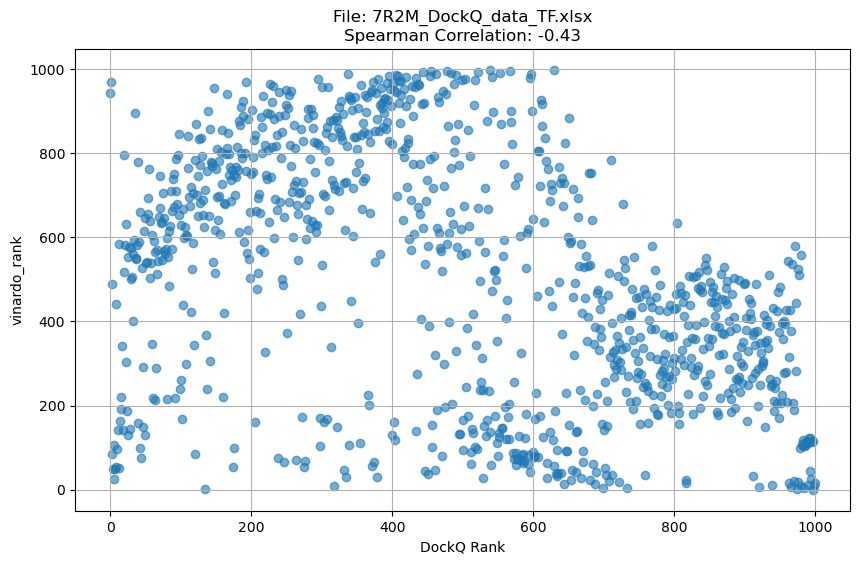

File: 7R2M_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.43245225586307745



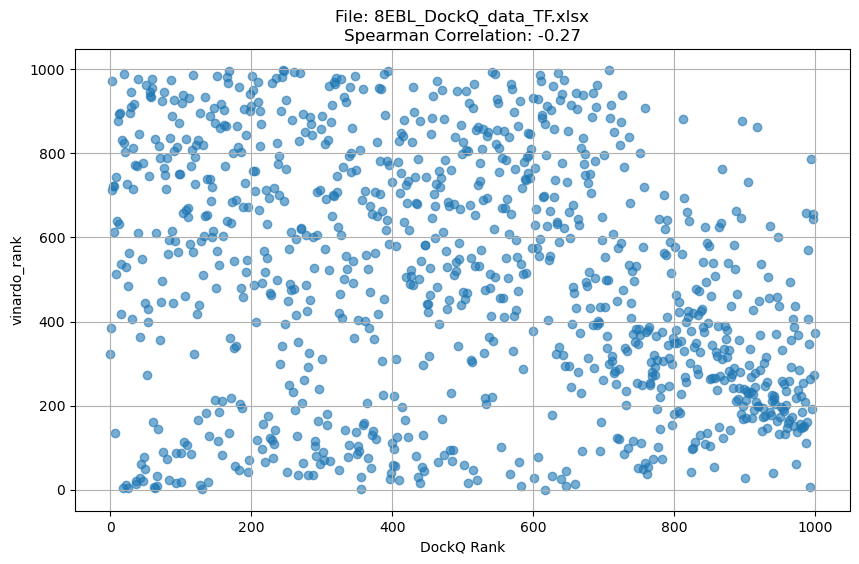

File: 8EBL_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.27188987588987595



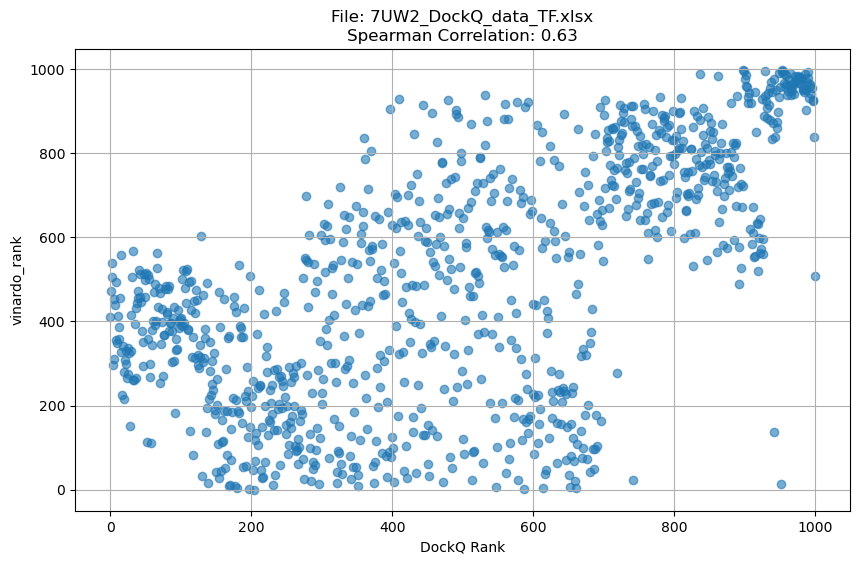

File: 7UW2_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.631745569216511



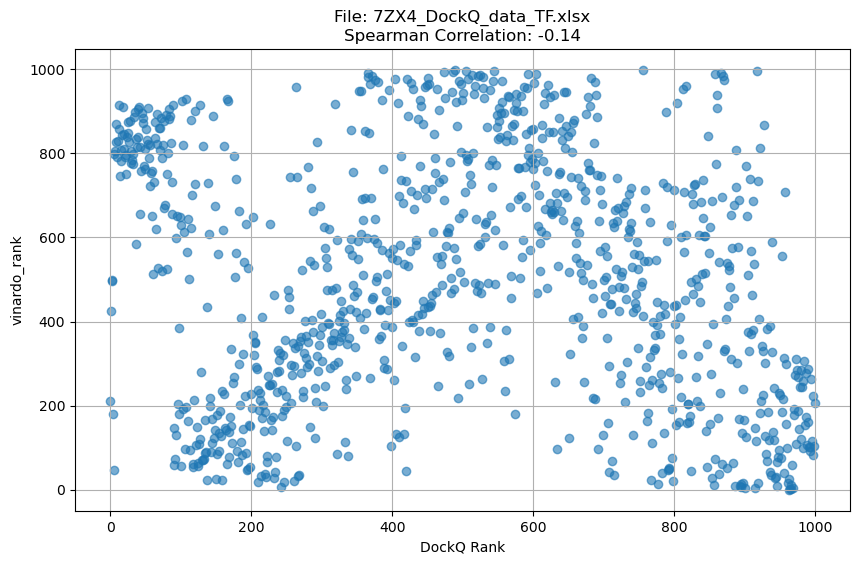

File: 7ZX4_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.14104632904632905



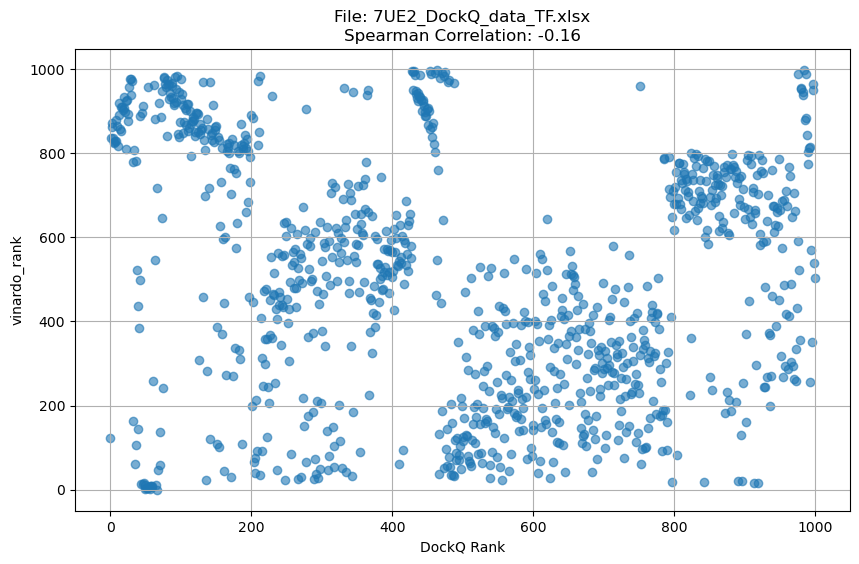

File: 7UE2_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.1609632959612919



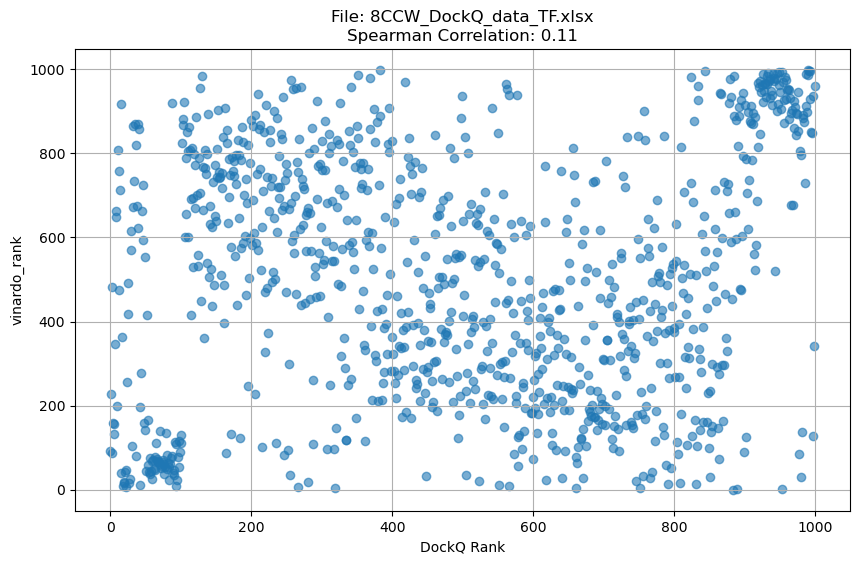

File: 8CCW_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.10681427881427884



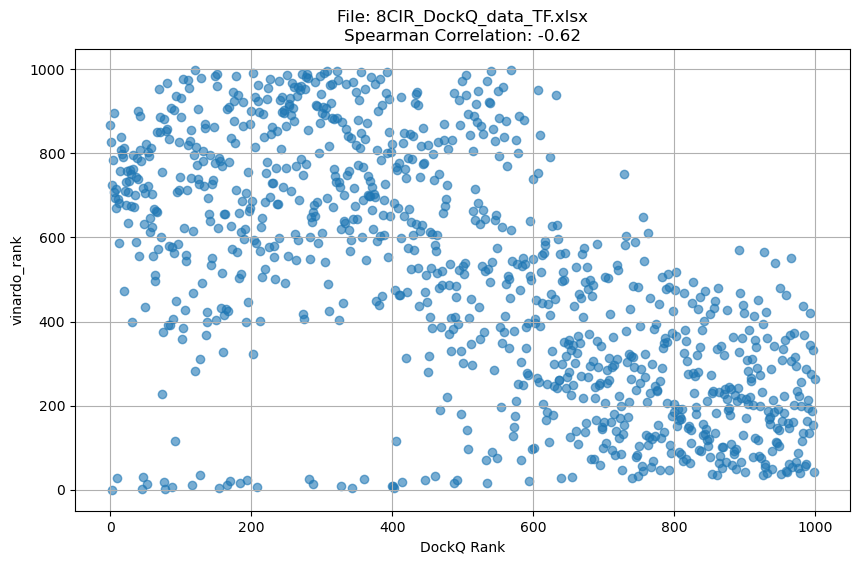

File: 8CIR_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.6212592452592454



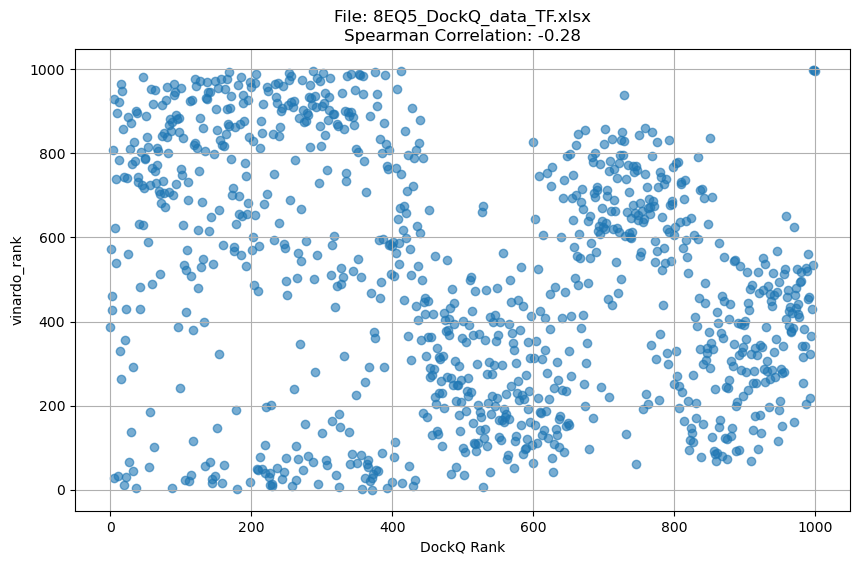

File: 8EQ5_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.28114063714063714



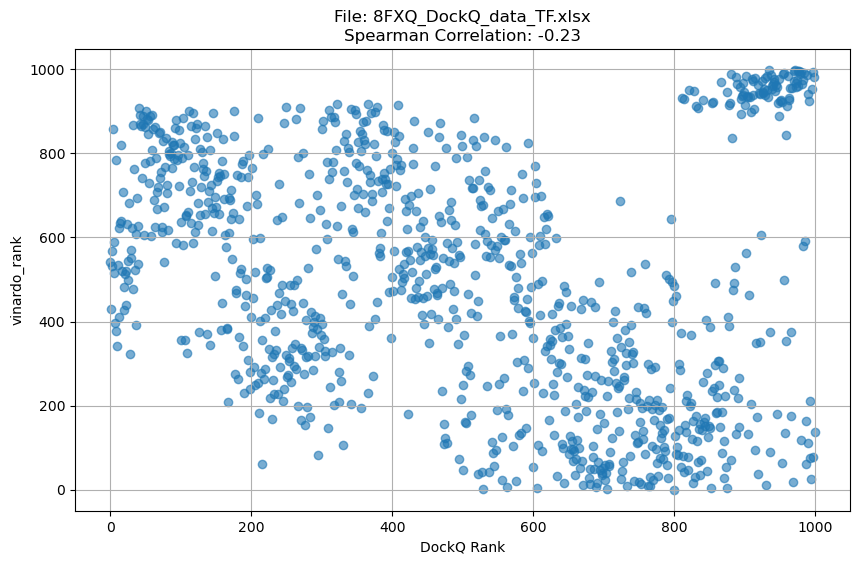

File: 8FXQ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.23393995793995795



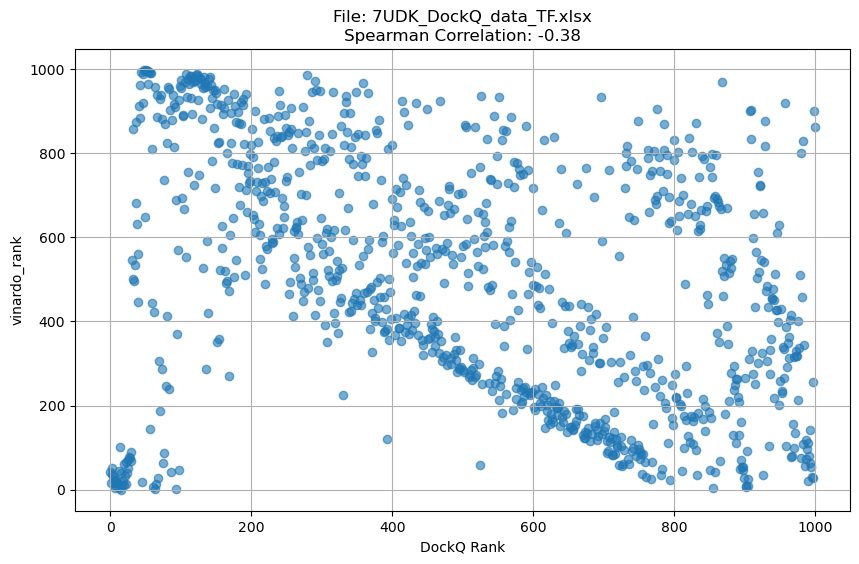

File: 7UDK_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3845603880433539



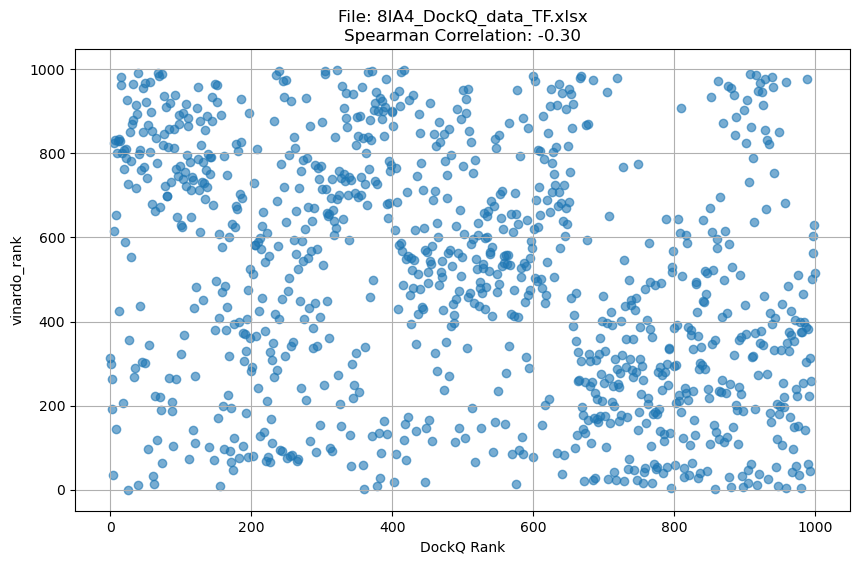

File: 8IA4_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.29667252867252875



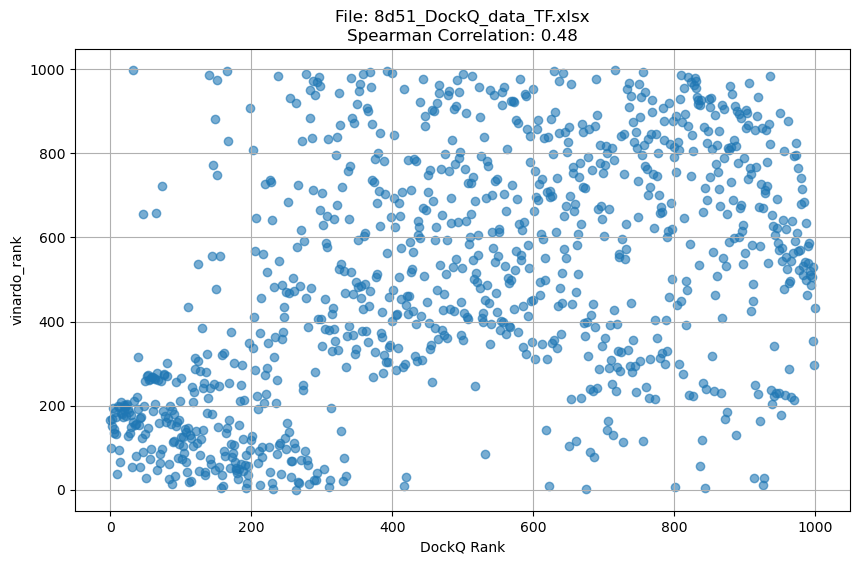

File: 8d51_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.4795859395859396



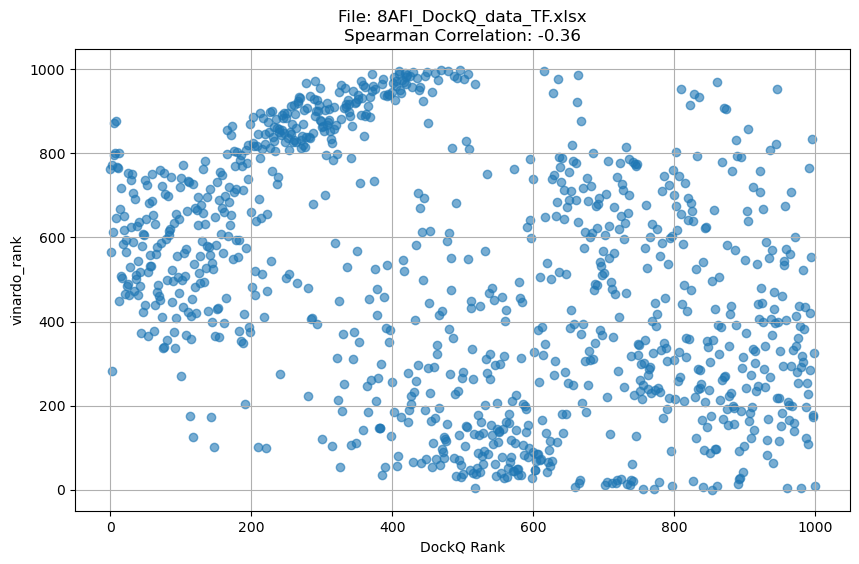

File: 8AFI_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3567937647937648



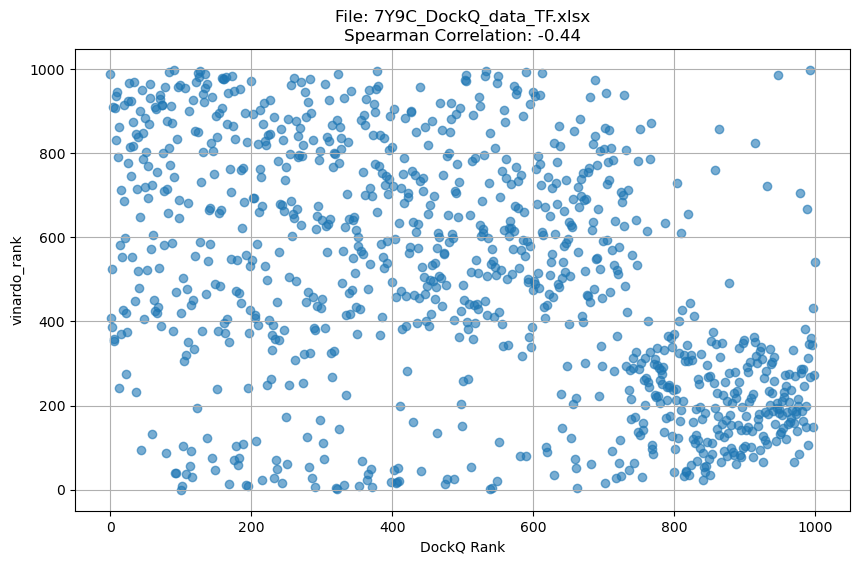

File: 7Y9C_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.4379525657922451



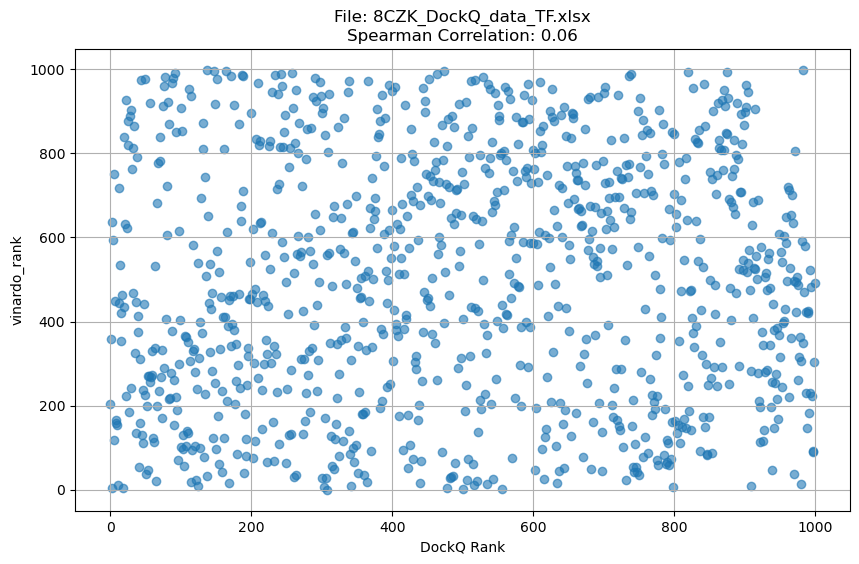

File: 8CZK_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.05604969204969206



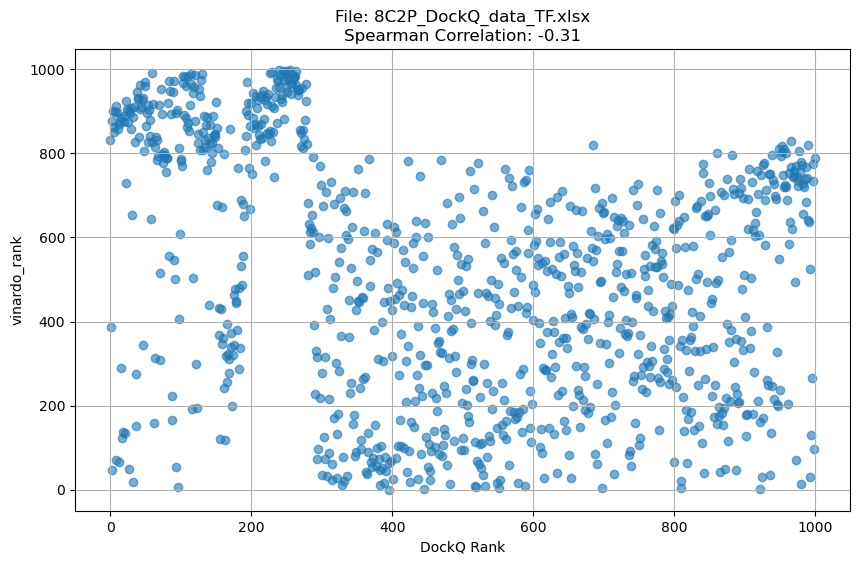

File: 8C2P_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3094049614049614



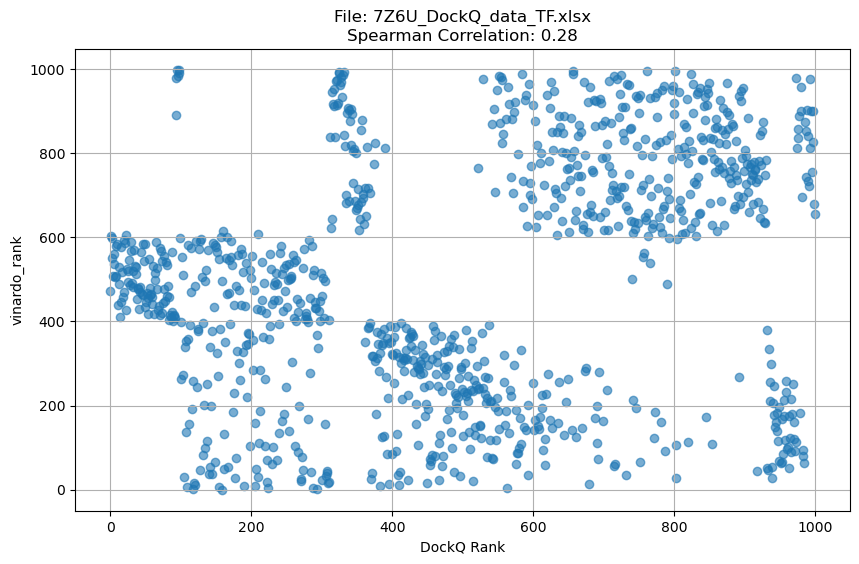

File: 7Z6U_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.2776169516209596



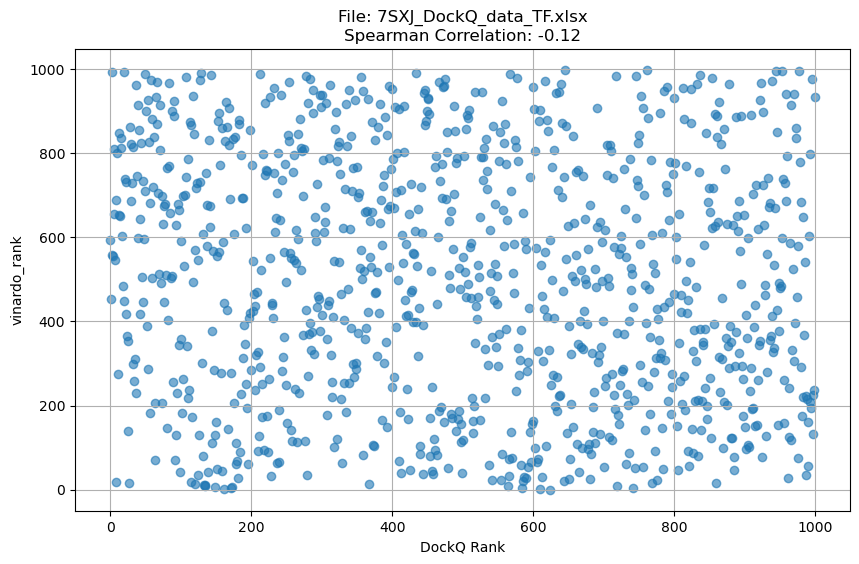

File: 7SXJ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.11620289227102852



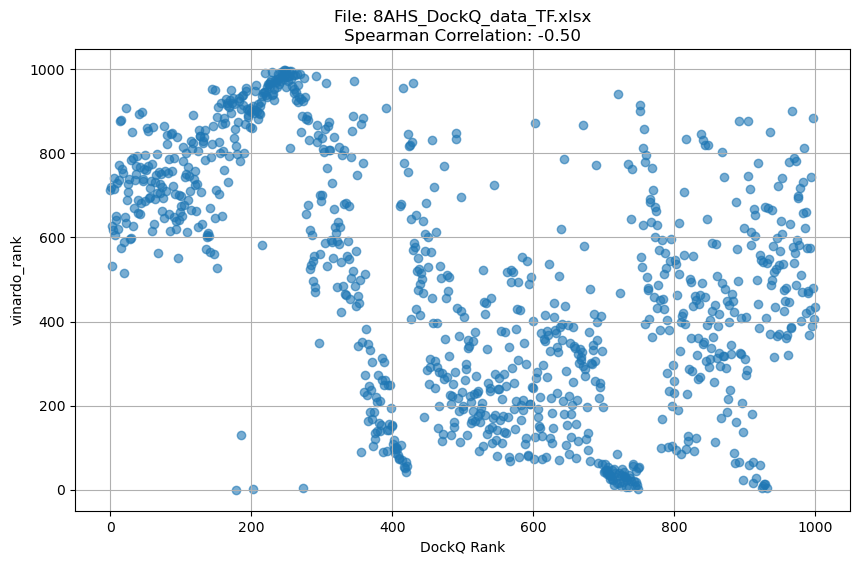

File: 8AHS_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.4954327474327475



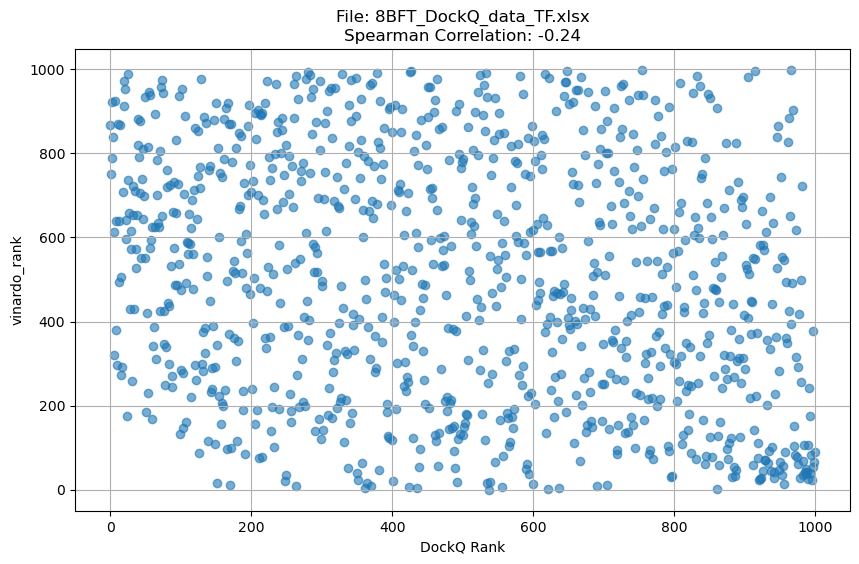

File: 8BFT_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.23726872526872533



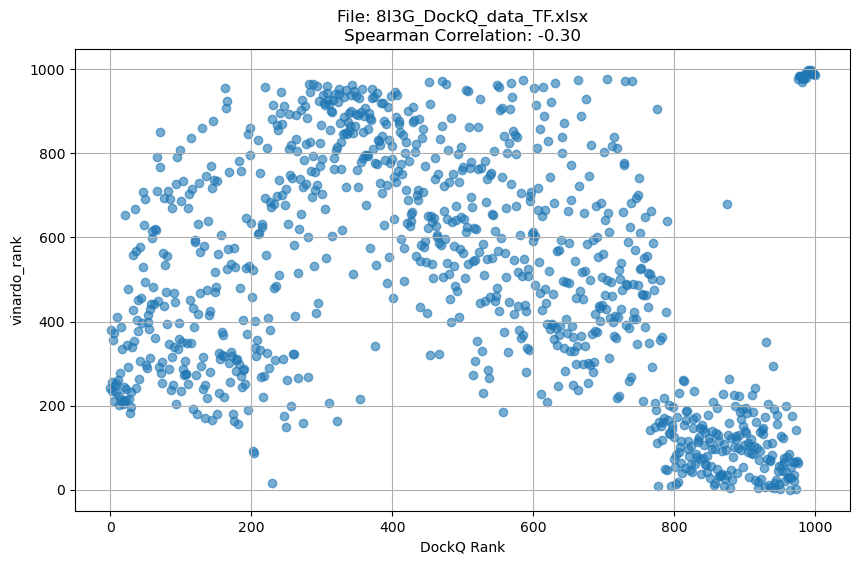

File: 8I3G_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3042075522075522



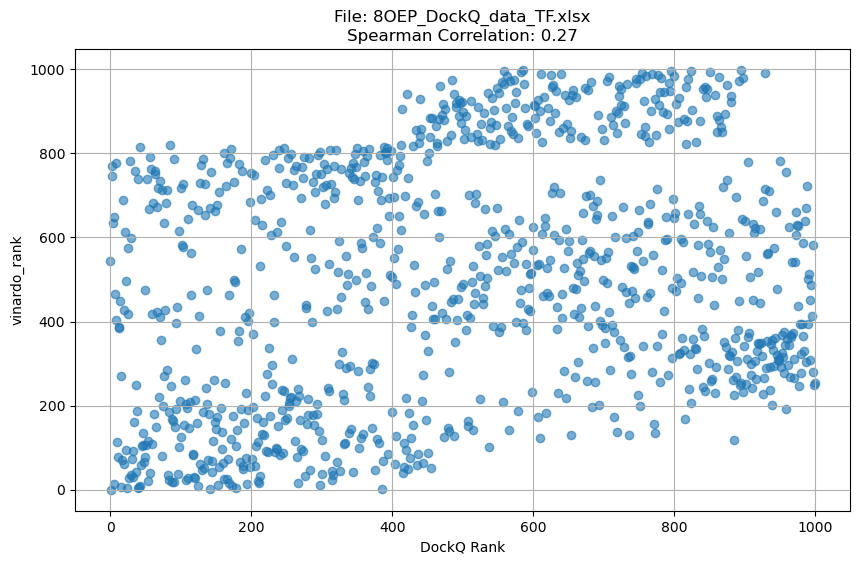

File: 8OEP_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.27031941031941037



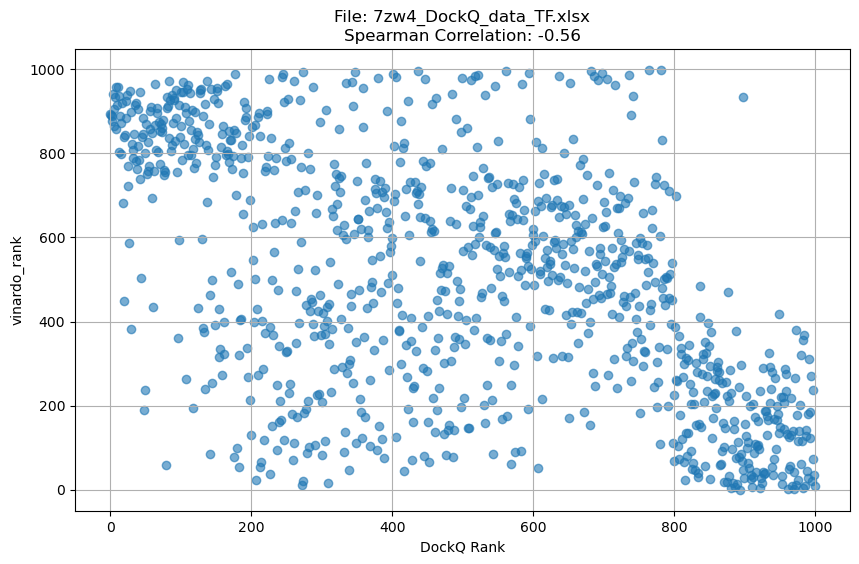

File: 7zw4_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.555877695877696



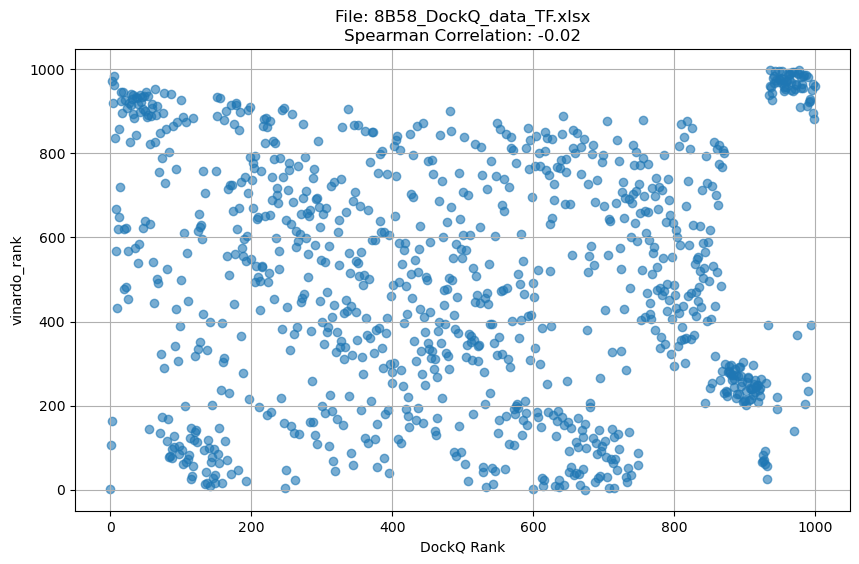

File: 8B58_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.017205509205509204



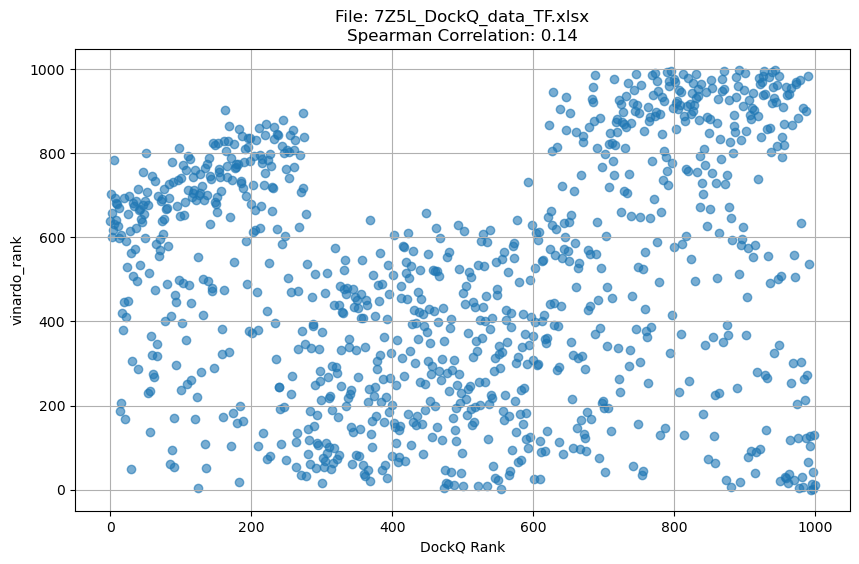

File: 7Z5L_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.13784757502993975



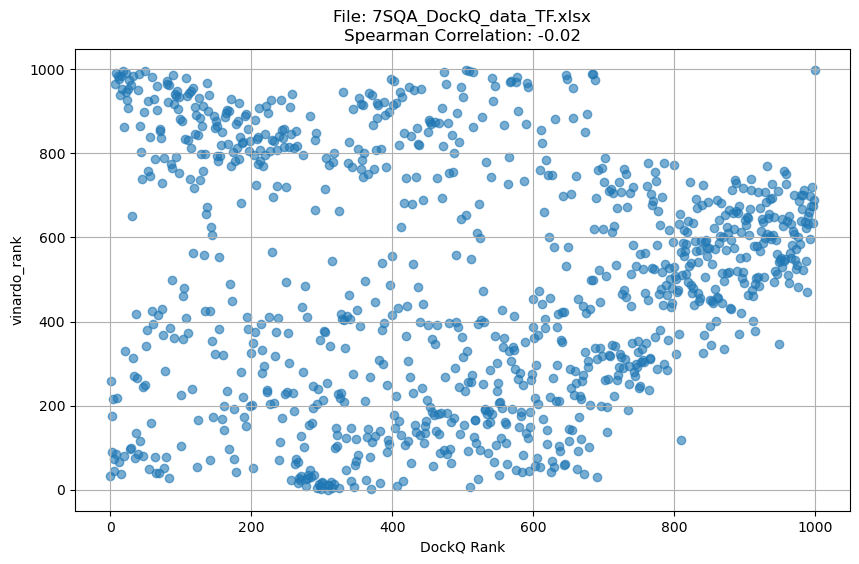

File: 7SQA_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.020635124635124635



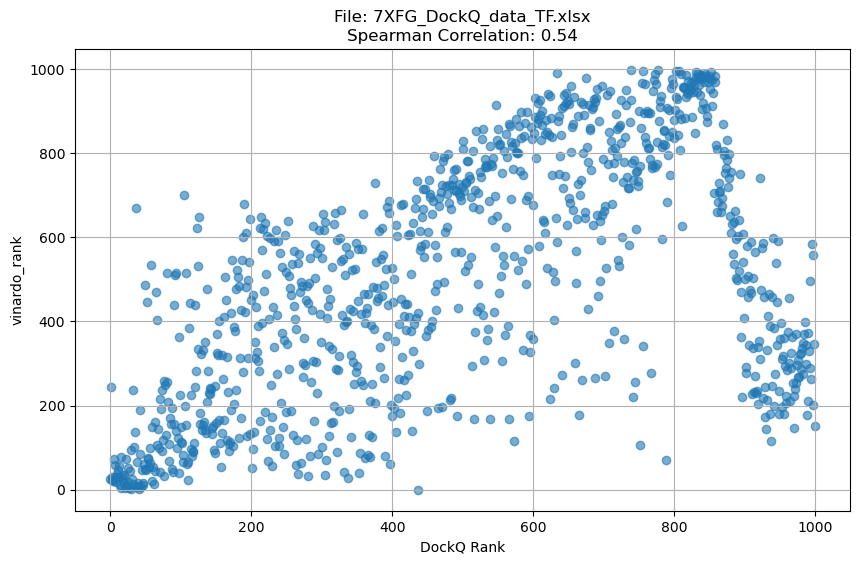

File: 7XFG_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.5400096288673443



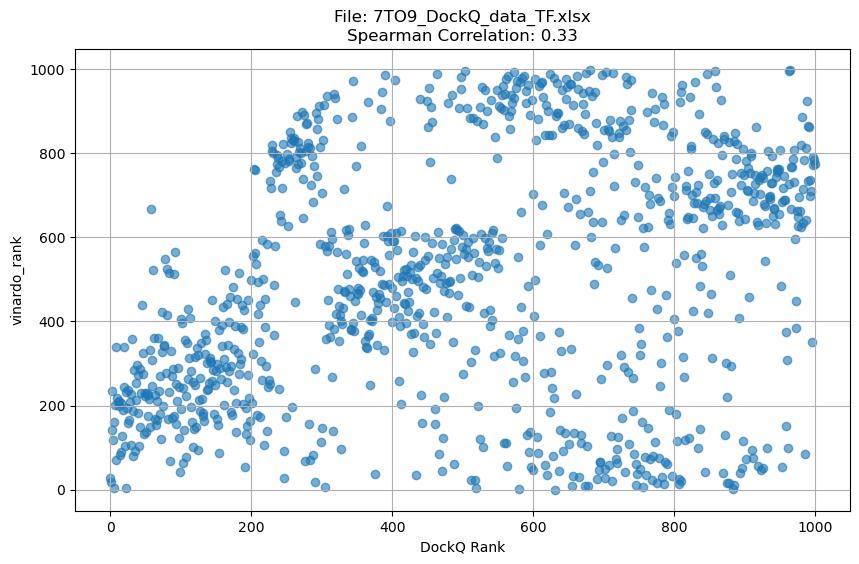

File: 7TO9_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3289346982252793



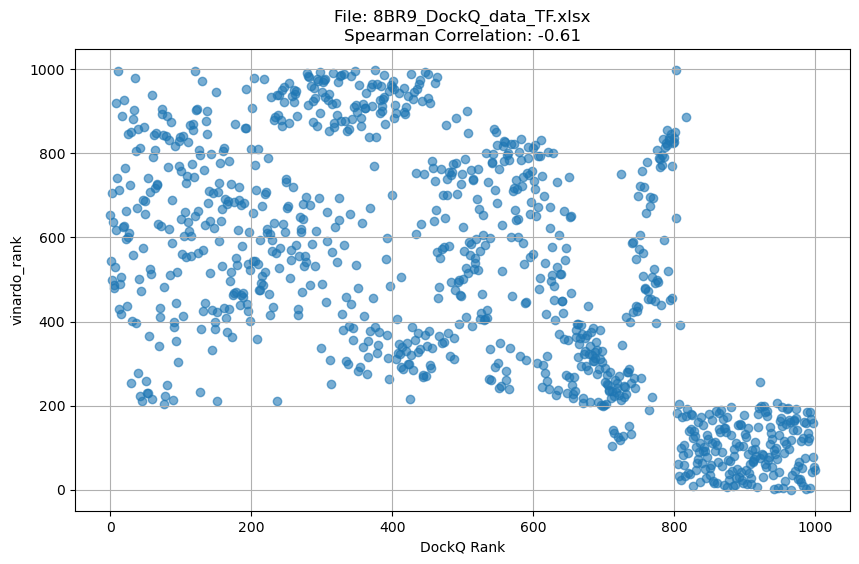

File: 8BR9_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.6084207324207325



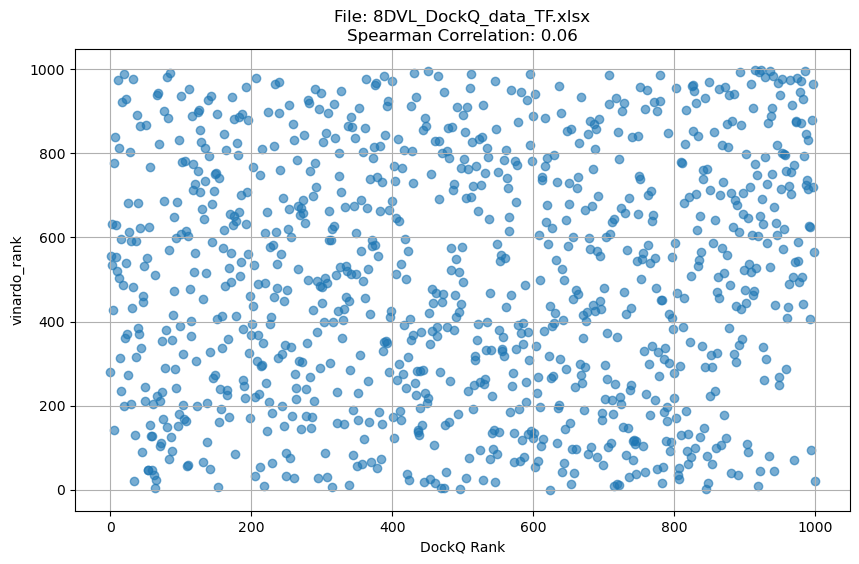

File: 8DVL_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.06199994599994601



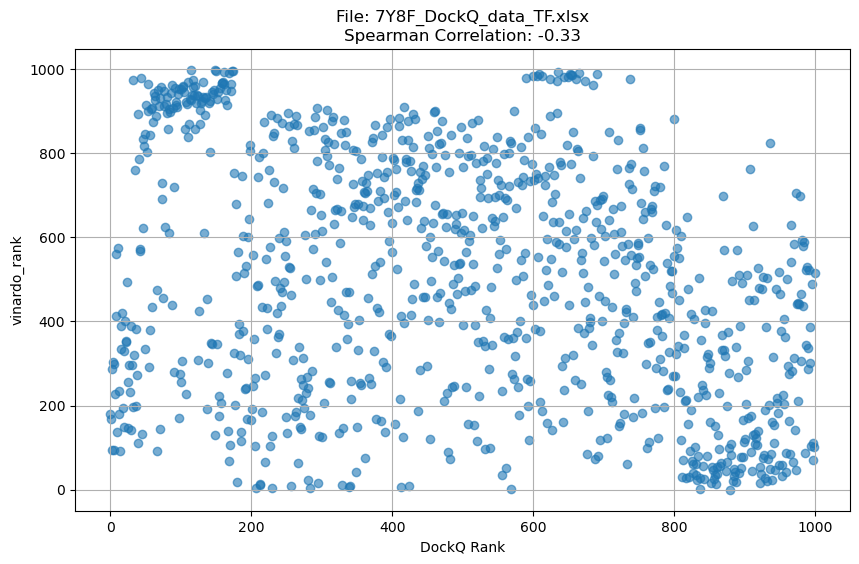

File: 7Y8F_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.3290869787623294



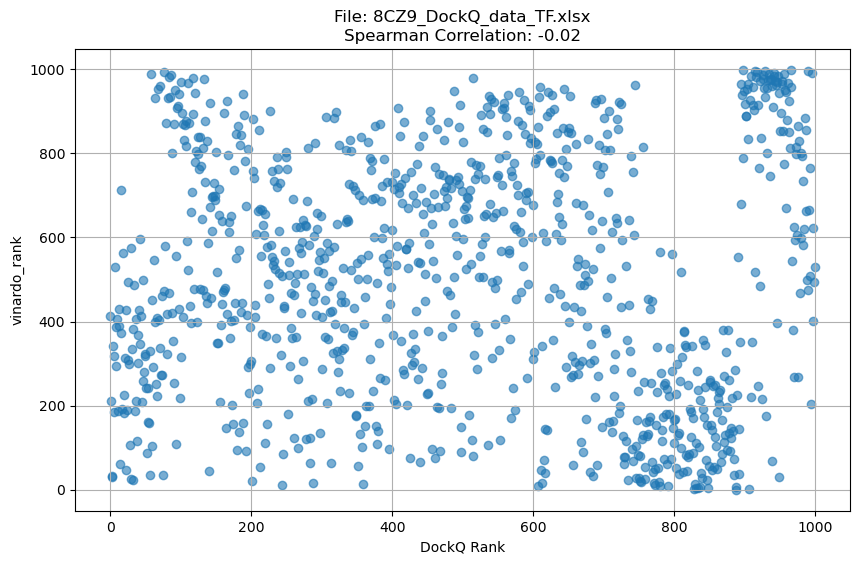

File: 8CZ9_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.02083878883878884



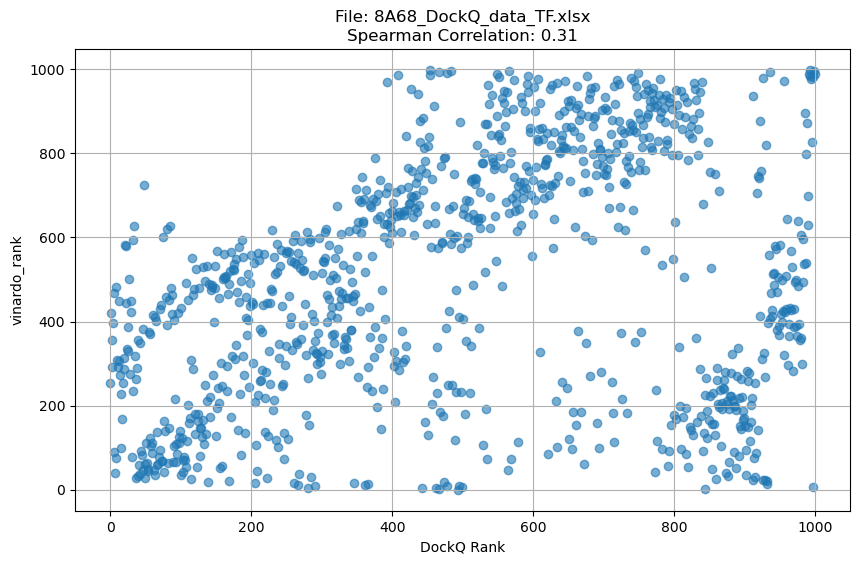

File: 8A68_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3055648855648856



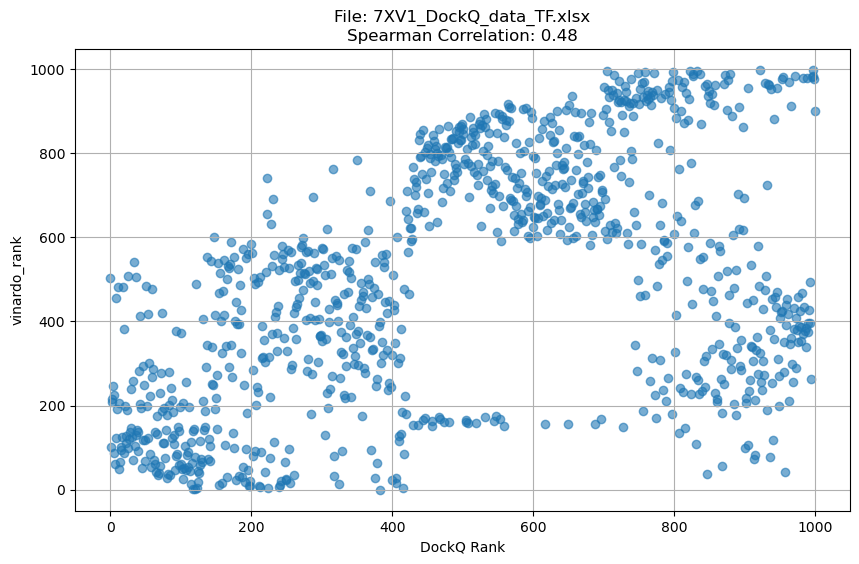

File: 7XV1_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.4750550470309989



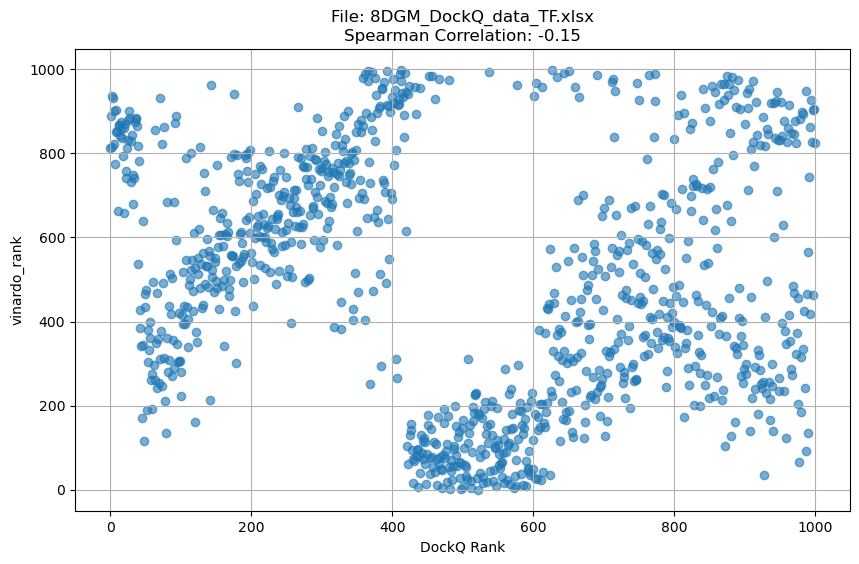

File: 8DGM_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.15045739845739847



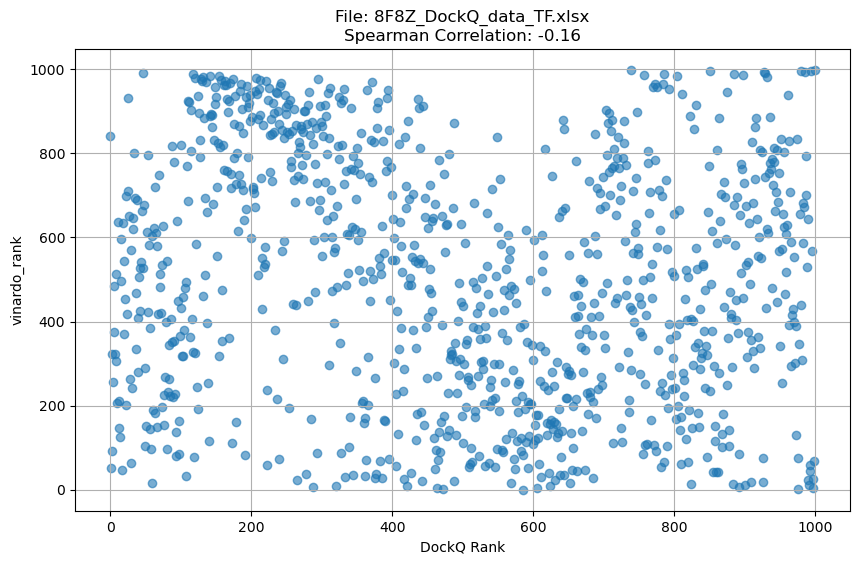

File: 8F8Z_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.15535388335388337



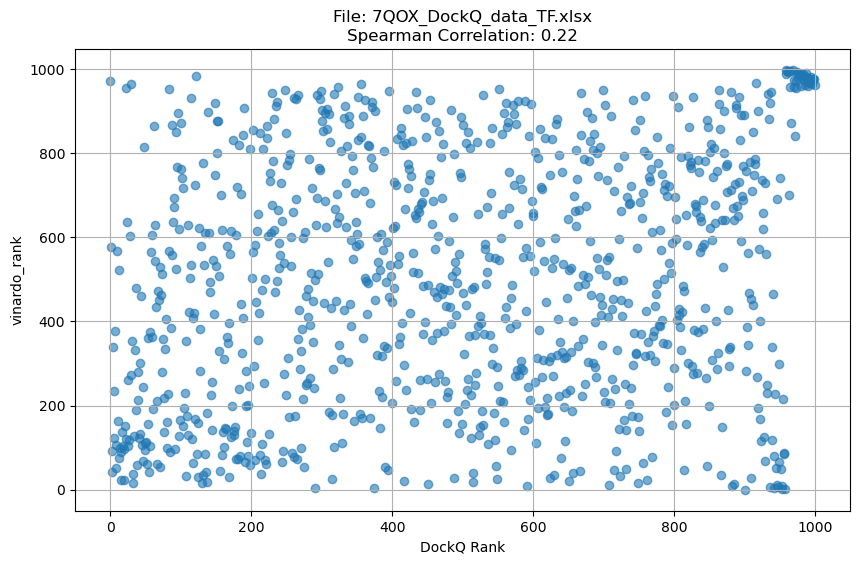

File: 7QOX_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.2244529298837916



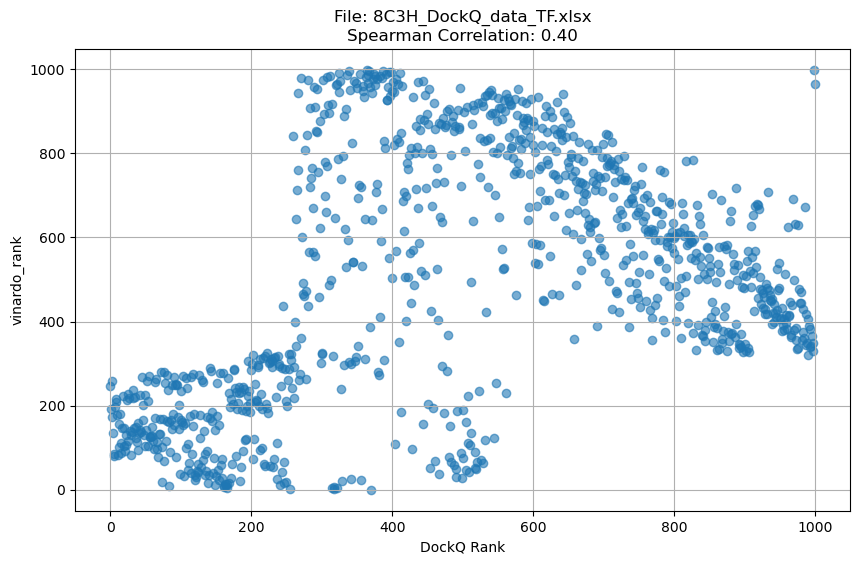

File: 8C3H_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.3998857958857959



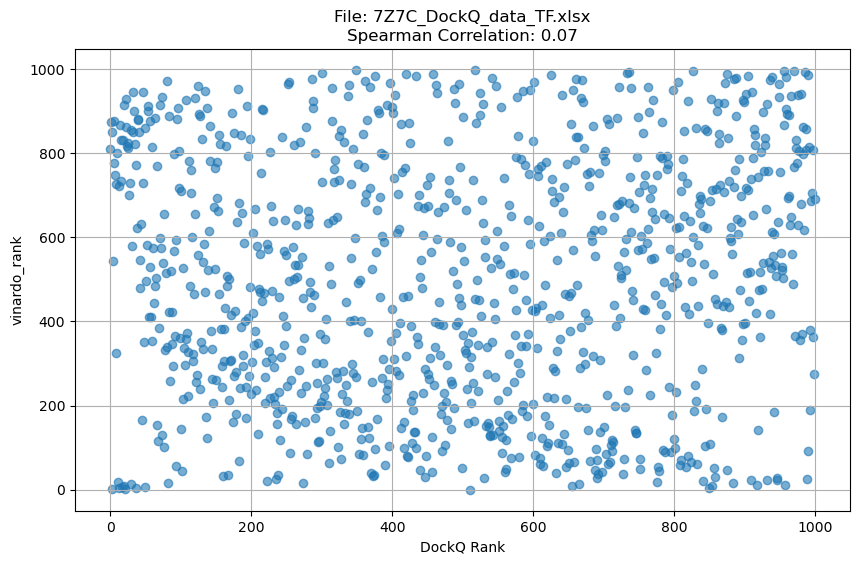

File: 7Z7C_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.06534839047464297



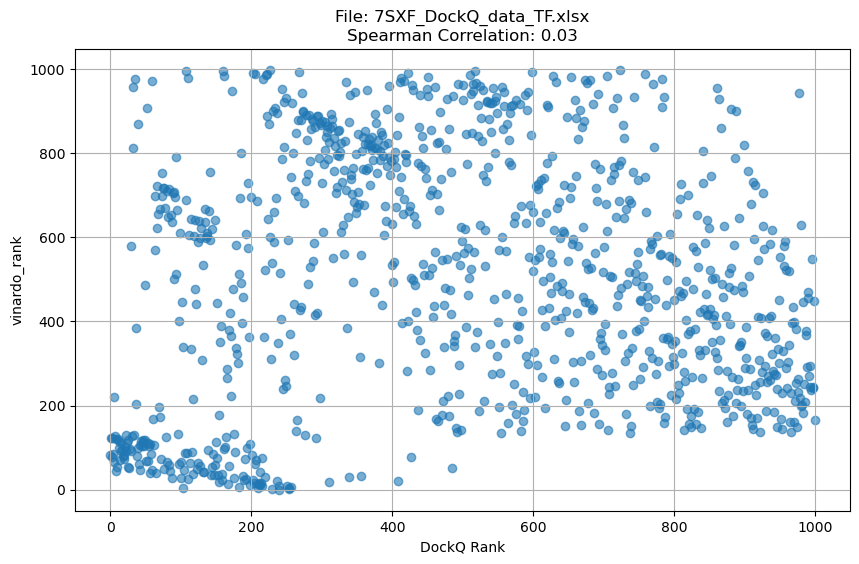

File: 7SXF_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.032713667575391014



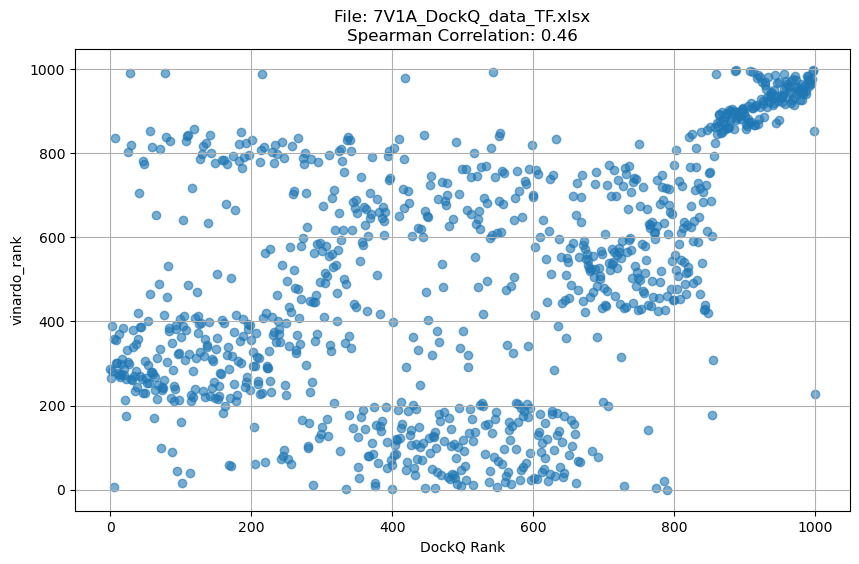

File: 7V1A_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.46232703244326484



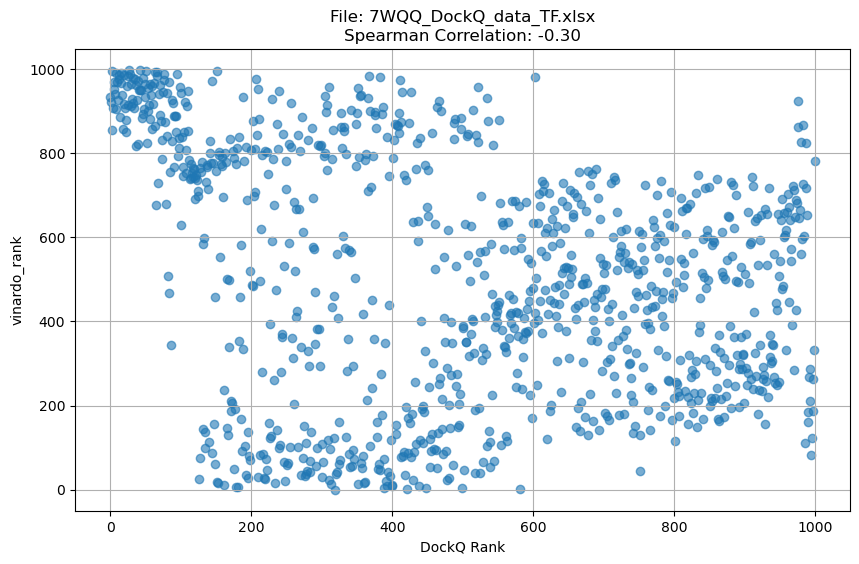

File: 7WQQ_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.2952897506725161



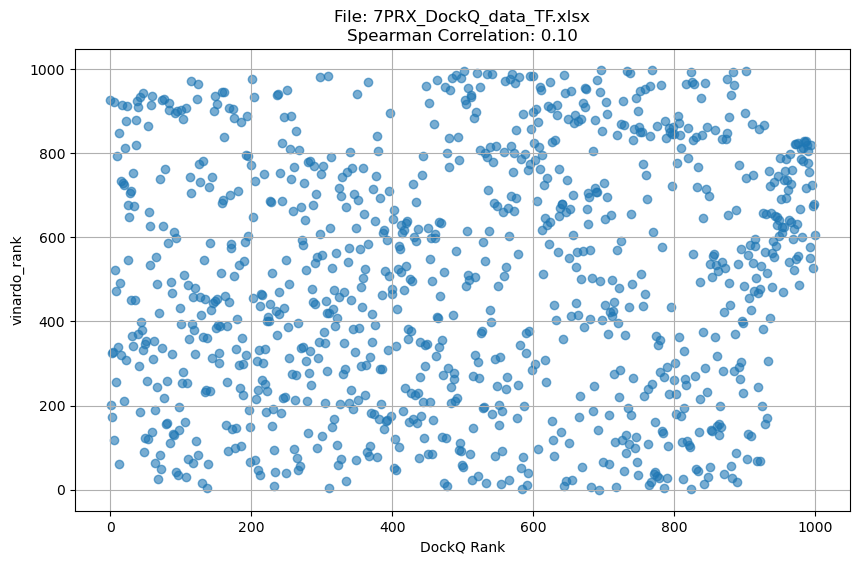

File: 7PRX_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.10366775593228497



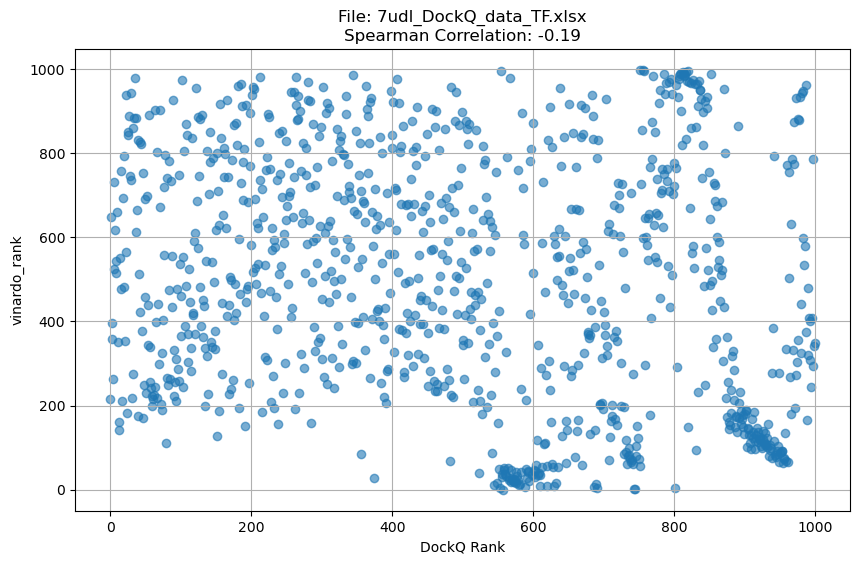

File: 7udl_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.19374541274741672



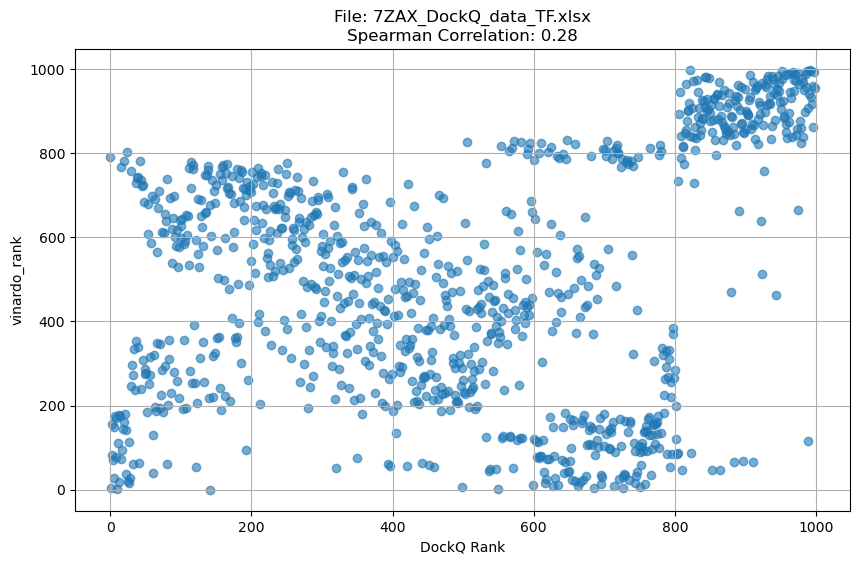

File: 7ZAX_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.282074407072403



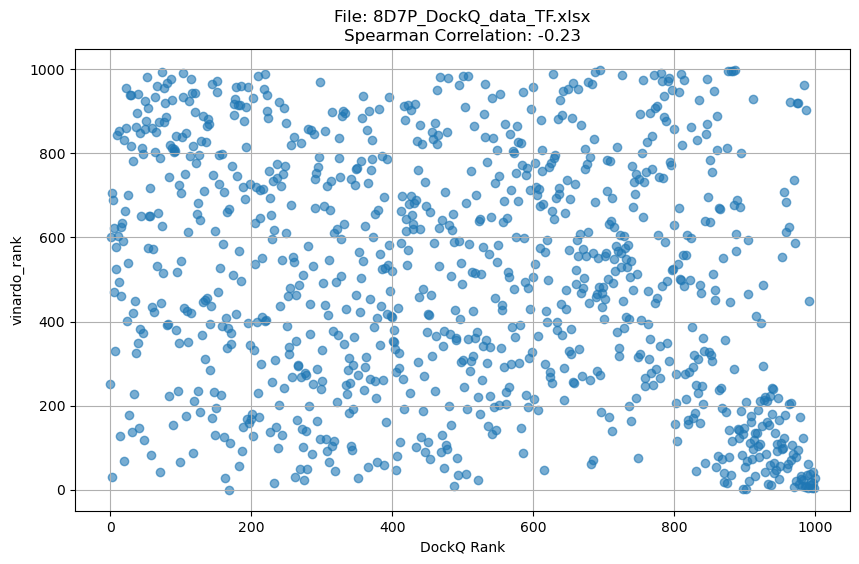

File: 8D7P_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.2343407823407824



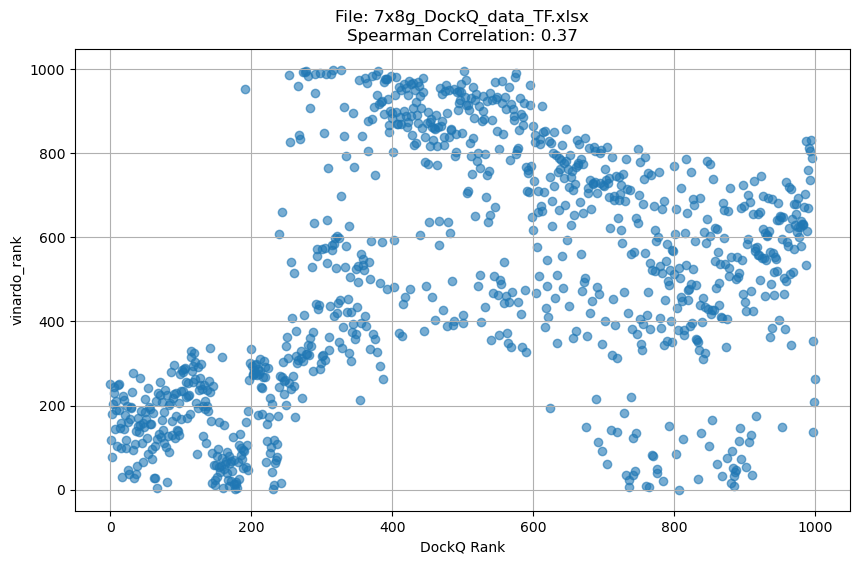

File: 7x8g_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.36943980453399283



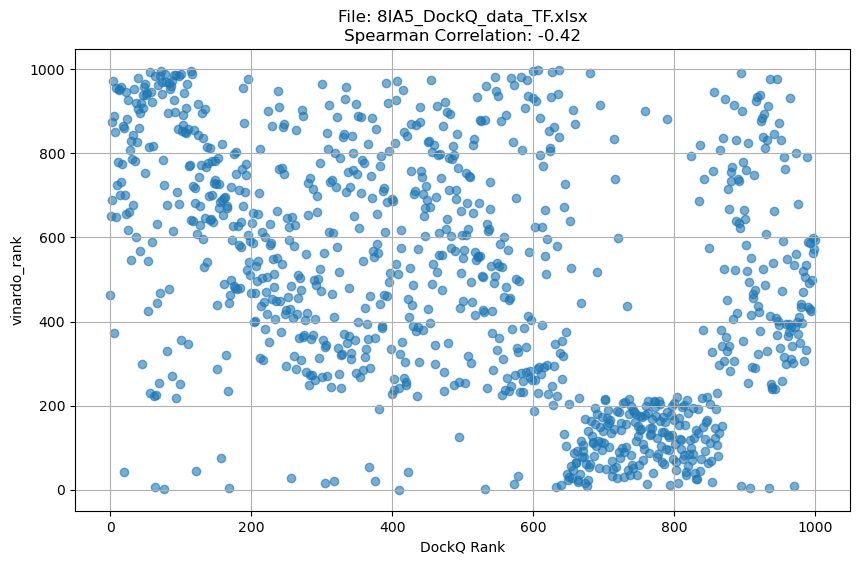

File: 8IA5_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.4160928680928681



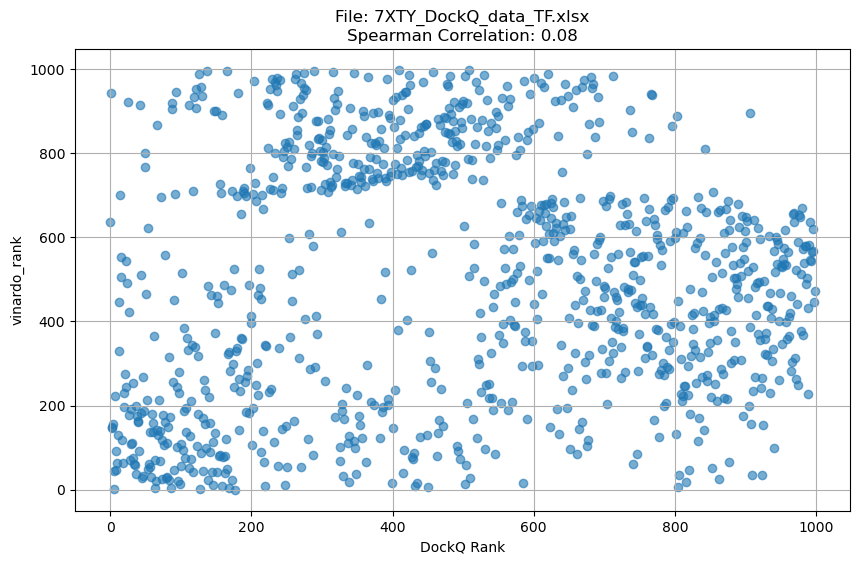

File: 7XTY_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.08228125921512694



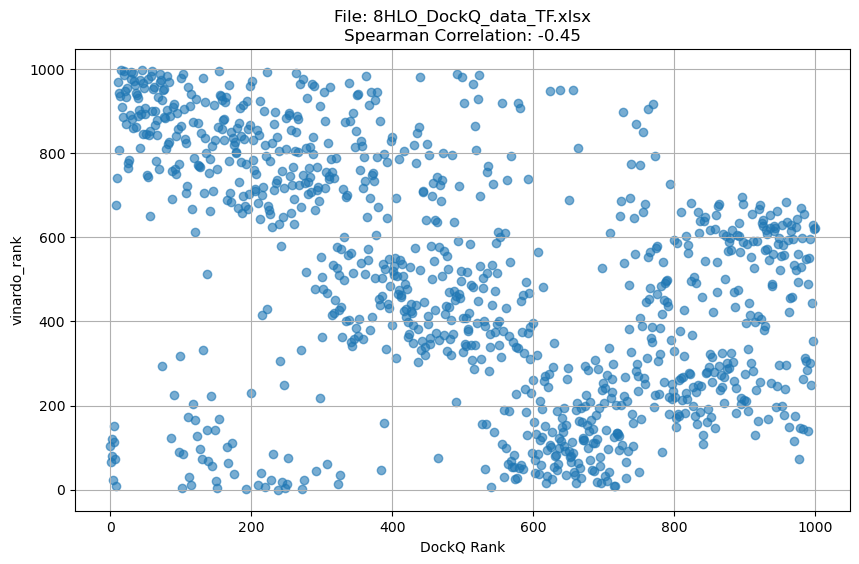

File: 8HLO_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.4491762744708636



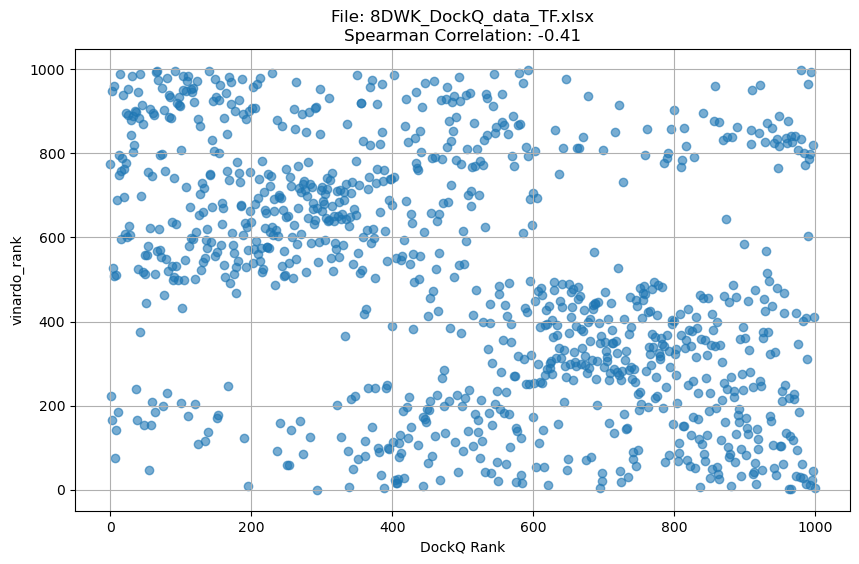

File: 8DWK_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.4052702372702373



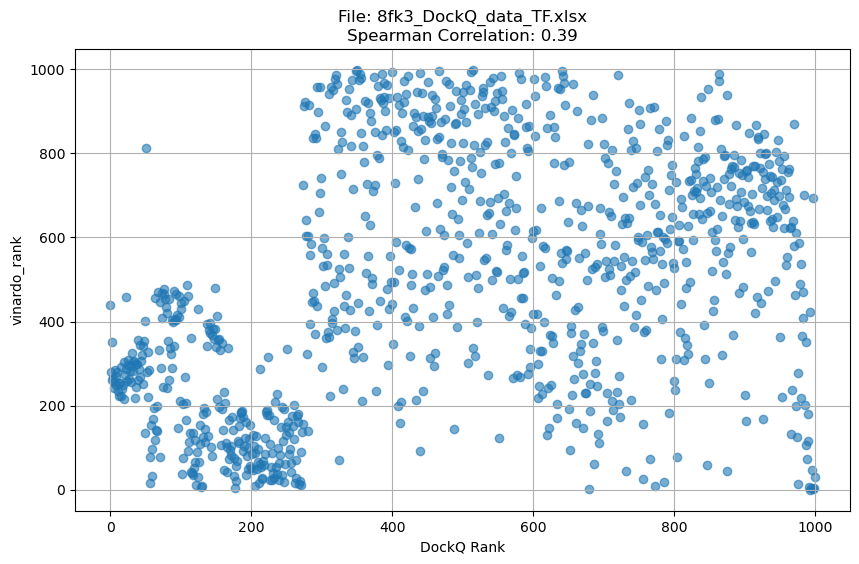

File: 8fk3_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.38641407841407843



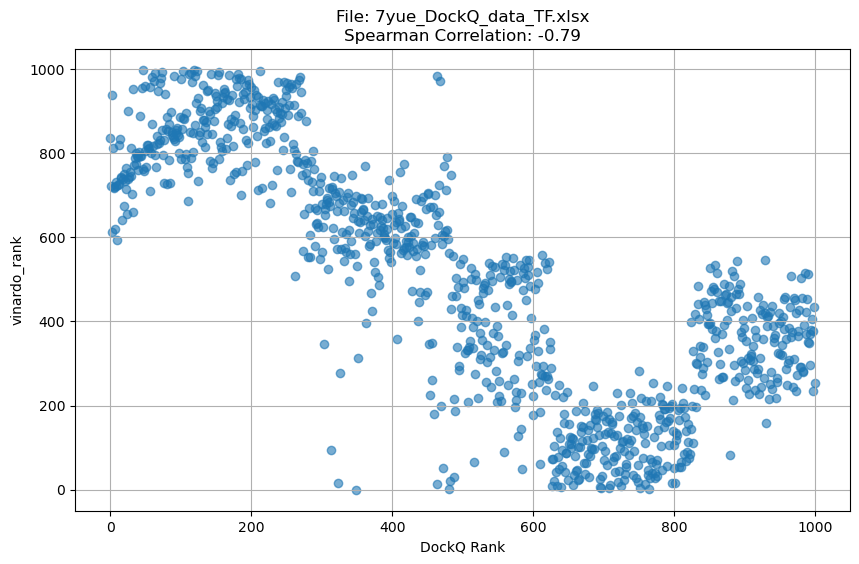

File: 7yue_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.7863106513326953



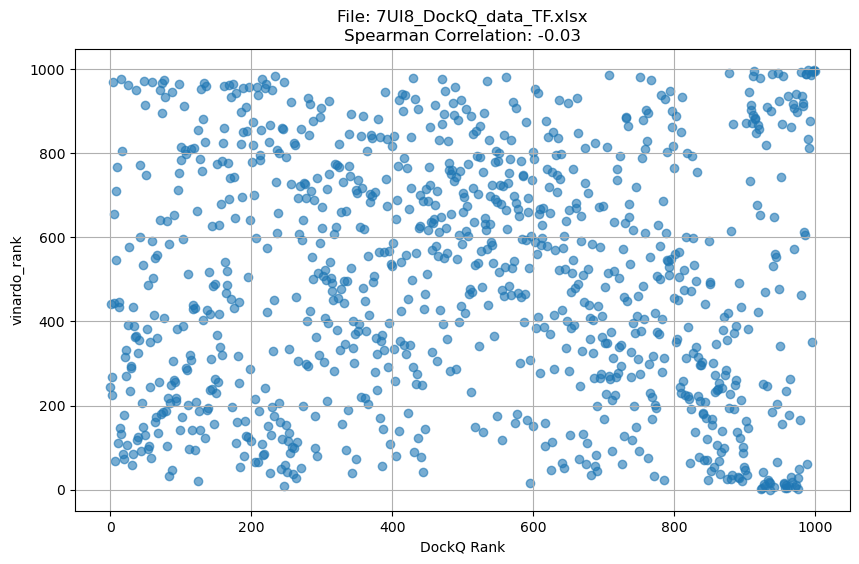

File: 7UI8_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.031901015243700606



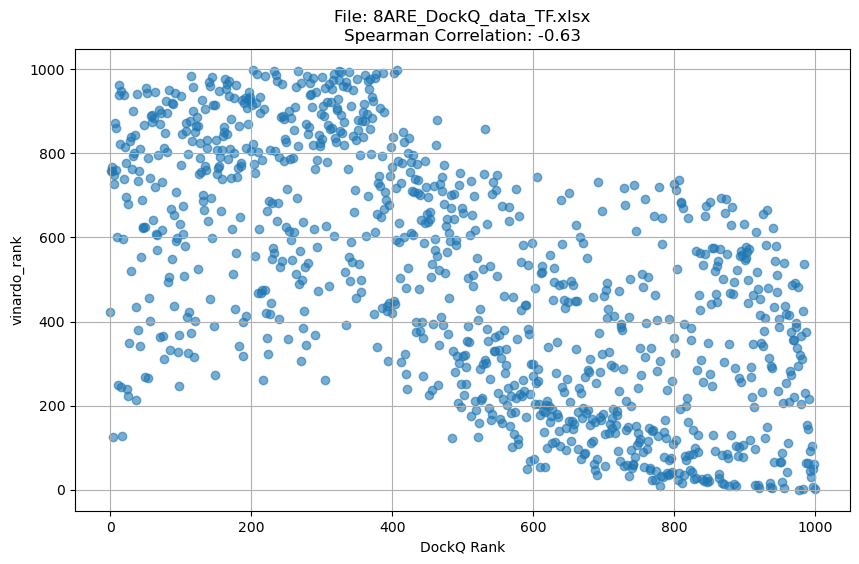

File: 8ARE_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: -0.6316653196653197



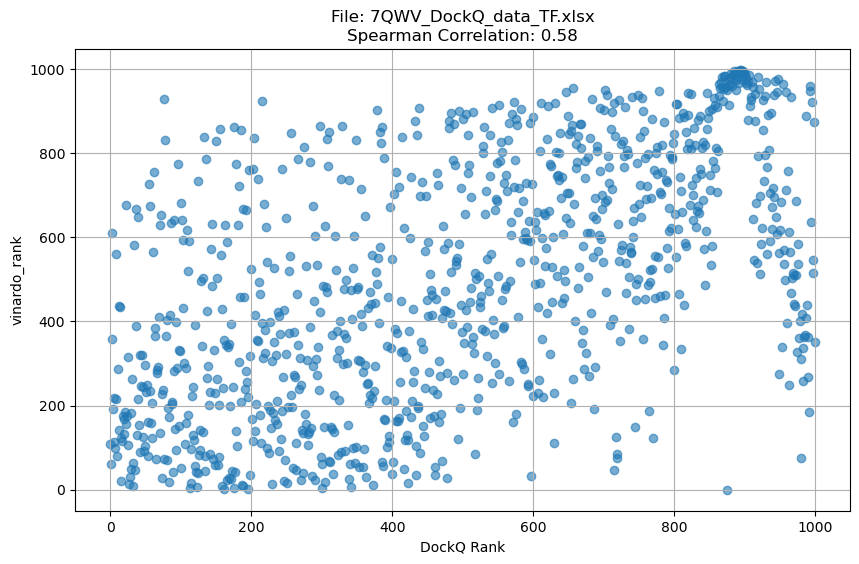

File: 7QWV_DockQ_data_TF.xlsx
Spearman Correlation Coefficient: 0.5774640211353638

Summary of Spearman correlations saved to /Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Spearman_Correlation/TF_Spearman/correlations_vinardo_TF.xlsx


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from zipfile import BadZipFile

def process_excel_files(directory_path, output_directory):
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)
    
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]
    correlations = []  # To store file names and their Spearman correlations
    
    for excel_file in excel_files:
        excel_file_path = os.path.join(directory_path, excel_file)
        
        try:
            xls = pd.ExcelFile(excel_file_path)
        except BadZipFile:
            print(f'Error: The file "{excel_file}" is not a valid Excel file or is corrupted.')
            continue
        except Exception as e:
            print(f'An unexpected error occurred while processing {excel_file}: {e}')
            continue
        
        if 'Vinardo' not in xls.sheet_names:
            print(f'The file "{excel_file}" does not contain a "Vinardo" sheet.')
            continue

        dockq_df = pd.read_excel(excel_file_path, sheet_name='Sheet')
        pyrosetta_df = pd.read_excel(excel_file_path, sheet_name='Vinardo')
        
        pyrosetta_rank_column = 'vinardo_rank'
        alpha_to_dockq_map = dockq_df.set_index('AlphaFold Rank')['DockQ Rank'].to_dict()
        pyrosetta_df['DockQ Rank'] = pyrosetta_df['alphafold rank'].map(alpha_to_dockq_map)
        
        filtered_pyrosetta_df = pyrosetta_df.dropna(subset=['DockQ Rank'])
        
        spearman_corr, _ = spearmanr(filtered_pyrosetta_df[pyrosetta_rank_column], filtered_pyrosetta_df['DockQ Rank'])
        
        plt.figure(figsize=(10, 6))
        plt.scatter(filtered_pyrosetta_df['DockQ Rank'], filtered_pyrosetta_df[pyrosetta_rank_column], alpha=0.6)
        plt.title(f'File: {excel_file}\nSpearman Correlation: {spearman_corr:.2f}')
        plt.xlabel('DockQ Rank')
        plt.ylabel('vinardo_rank')
        plt.grid(True)
        plt.show()

        # Append file name and Spearman correlation to the list
        correlations.append({'File Name': excel_file, 'Spearman Correlation': spearman_corr})
        print(f'File: {excel_file}\nSpearman Correlation Coefficient: {spearman_corr}\n')
    
    # Convert list to DataFrame
    correlations_df = pd.DataFrame(correlations)
    
    # Path for the new Excel file
    output_file_path = os.path.join(output_directory, 'correlations_vinardo_TF.xlsx')
    
    # Save DataFrame to an Excel file
    correlations_df.to_excel(output_file_path, index=False)
    print(f'Summary of Spearman correlations saved to {output_file_path}')

# Example usage
directory_path = os.path.join(config['output_directory'], 'vinardo_DockQ_TF')
output_directory = config['Spearman_Correlation_directory_TF']
process_excel_files(directory_path, output_directory)


In [8]:
import pandas as pd
import os

def calculate_positive_negative_percentages(file_path):
    # Load the Excel file
    data = pd.read_excel(file_path)
    
    # Count the total number of entries
    total_entries = len(data['Spearman Correlation'])
    
    # Count the number of positive and negative Spearman Correlation values
    positive_count = data[data['Spearman Correlation'] > 0].shape[0]
    negative_count = data[data['Spearman Correlation'] < 0].shape[0]
    
    # Calculate percentages
    positive_percentage = (positive_count / total_entries) * 100
    negative_percentage = (negative_count / total_entries) * 100
    
    return positive_percentage, negative_percentage

# Example usage
output_directory = config['Spearman_Correlation_directory_TF']
file_name = 'correlations_vinardo_TF.xlsx'
file_path = os.path.join(output_directory, file_name)

positive_percentage, negative_percentage = calculate_positive_negative_percentages(file_path)
print(f"Positive Vinardo_Spearman Correlation: {positive_percentage:.2f}%")
print(f"Negative Vinardo_Spearman Correlation: {negative_percentage:.2f}%")


Positive Vinardo_Spearman Correlation: 41.07%
Negative Vinardo_Spearman Correlation: 58.93%


In [9]:
import os
import pandas as pd

# Directory containing the Excel files
directory_path = os.path.join(config['output_directory'], 'vinardo_DockQ_TF')

# Initialize a list to store the results
results = []

# List all Excel files in the directory
excel_files = [file for file in os.listdir(directory_path) if file.endswith('.xlsx')]

for file_name in excel_files:
    file_path = os.path.join(directory_path, file_name)
    xls = pd.ExcelFile(file_path)

    # Extract pdb_id from file name
    pdb_id = file_name.split('_')[0]

    # Load data from "Vinardo" sheet
    vinardo_df = pd.read_excel(file_path, sheet_name='Vinardo')
    structure_name_for_rank_zero = vinardo_df[vinardo_df['vinardo_rank'] == 0]['file'].iloc[0].replace('.pdb', '.pdb_clean')

    # Load data from "Sheet" sheet
    sheet_df = pd.read_excel(file_path, sheet_name='Sheet')

    # Highest DockQ score
    highest_dockq_score = sheet_df['DockQ'].max()

    # DockQ score for the structure from Vinardo
    highest_vinardo_dockq_score = sheet_df[sheet_df['File Name'].str.contains(structure_name_for_rank_zero)]['DockQ'].max()

    # Calculate Loss
    score_Loss = highest_dockq_score - highest_vinardo_dockq_score

    # Append results
    results.append([pdb_id, highest_dockq_score, highest_vinardo_dockq_score, score_Loss])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['File Name', 'DockQ', 'Vinardo ranked', 'Loss'])

# Save the results into a new Excel file
output_path = os.path.join(config['DockQ_Loss_directory_TF'], 'Vinardo_loss_TF.xlsx')
results_df.to_excel(output_path, index=False)

print(f"Results have been saved to {output_path}")


Results have been saved to /Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Loss/TF_Loss/Vinardo_loss_TF.xlsx
